In [31]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline

In [46]:
# #File Handling
# if sys.platform==('win32'):
#     os.chdir('\\')
#     print(os.getcwd())
os.chdir('C:\\Users\Patrick\Documents\programs\sensory-restricted-analysis')

In [94]:
pathname = r"C:\Users\Patrick\Datasets\sr\SR"
time_path = pathname + r"\1.Data\20180305.1\20180305.1.2\GCaMP_Time_Pre.csv"
gcamp_data_path = pathname + r'\1.Data\20180305.1\20180305.1.2\ROI-profiles.txt'
kinematic_data_path = pathname + r'\1.Data\20180305.1\20180305.1.2\20180305_Fly1_THDDC_SR_2.dat'
start_stop_data_path = pathname + r'\1.Data2\20180305.1\20180305.1.2\1.Traces\StopStart_Times_Exact.csv'
light_times_path = pathname + r'\1.Data\20180305.1\20180305.1.2\Light_Times.xlsx'

In [124]:
f = open(time_path, 'r')
times = [float(i) for i in (f.read().split(','))]
GCaMP_Time = np.asarray(times)
f.close()

In [78]:
df = pd.read_csv(gcamp_data_path, header=None)
FicTracData = np.genfromtxt(kinematic_data_path, delimiter=',')

In [79]:
df_trans = df.T
tag = df_trans.iloc[0][0]
header = df_trans.iloc[1]
for idx, item in enumerate(header):
    if idx < 8:
        header[idx] = item.strip() + '_red'
    else:
        header[idx] = item.strip() + '_green'
    
df_trans.drop(axis=0, index=[0,1], inplace=True)

df_trans = df_trans.reset_index(drop=True)
df_trans.columns=header.T
df_trans['time'] = pd.Series(times)
GCamp_data = df_trans

In [80]:
class Metadata(object):

    def __init__(self, year, month, day, fly_no, THDDC, SR):
        self.day = day
        self.month = month
        self.year = year
        self.fly_no = fly_no
        self.THDDC = THDDC
        self.SR = SR

def metadata_assigner(tag):
    splits = tag.split('_')
    year = splits[0][3:7]
    month = splits[0][7:9]
    day = splits[0][9:11]
    fly_no = splits[1][-1]
    if splits[2]=='THDDC':
        THDDC = True
    else:
        THDDC = False
    if splits[3] == 'SR':
        SR = True
    else:
        SR = False
        
    metadata_blob = Metadata(year, month, day, fly_no, THDDC, SR)
    return metadata_blob
#USE: new_metadata = metadata_assigner(tag)

In [81]:
#Ported from Ari Matlab Code "scrap_test.m"

#Why -9 -----------------------------------------------------------------------<
GCamp_Time = GCamp_Time_Pre - GCamp_Time_Pre[0]
Trace_Length = GCamp_Time[-1-9]

xpos_pre=FicTracData[:,14]
ypos_pre=FicTracData[:,15]
Roll_Pre=FicTracData[:,5]
Pitch_Pre=FicTracData[:,6]
Ang_Pre=FicTracData[:,7]
Heading_Pre=FicTracData[:,16]
Frames_Pre=FicTracData[:,0].astype(int)

In [84]:
#Normalize heading between pi and negative pi
pi = 3.14159
Heading1=((Heading_Pre+pi)%(2*pi))-pi;

#Import The time that the light turns on            
import openpyxl
wb=openpyxl.load_workbook(light_times_path)

sheet = wb['Sheet1']
Lights_On_1 = sheet['A1'].value - 1
Lights_On_2 = sheet['A2'].value - 1

#Get Proper Index for start and stop
Start_frame=np.where(Frames_Pre==Lights_On_1)[0][0]
End_frame=np.where(Frames_Pre==Lights_On_2)[0][0]

# Cut motion data appropriately
Roll=Roll_Pre[Start_frame:End_frame]
Pitch=Pitch_Pre[Start_frame:End_frame]
Ang=Ang_Pre[Start_frame:End_frame]
Heading=Heading1[Start_frame:End_frame]
Frames=Frames_Pre[Start_frame:End_frame]
RATE=(Frames[-1]-Frames[0])/Trace_Length
FicTrac_Time_Real1=Frames*(1/RATE)
FicTrac_Time_Real=FicTrac_Time_Real1-FicTrac_Time_Real1[0]
xpos_PRE=xpos_pre[Start_frame:End_frame]
ypos_PRE=ypos_pre[Start_frame:End_frame]
xpos=xpos_PRE-xpos_PRE[0];
ypos=ypos_PRE-ypos_PRE[0];

#Combine Roll, Pitch, and Ang to create Motion
Motion = np.linalg.norm([Pitch, Ang, Roll], axis=0)
            

C:\Users\Patrick\Anaconda3\lib\site-packages\openpyxl\reader\worksheet.py:318: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [85]:
def CIRF_conv(timeseries):       
    # ---------------------------------------------------------------------
    # INPUT: Time series kinematic data from experimental data collection, dim([1,N])
    # RETURNS: Time series convolved with CIRF Function
    # ---------------------------------------------------------------------
    CIRF = -1*(np.power(2, (-FicTrac_Time_Real/0.175)) - np.power(2, (-FicTrac_Time_Real/0.55)))
    ts = timeseries
    #Pad the ts Data
    ts_Padded_Front = np.append((np.zeros((1,ts.shape[0]),dtype='float64')), (np.transpose(ts)))
    ts_Padded = np.append(ts_Padded_Front, (np.zeros((1,ts.shape[0]),dtype='float64')))
    #Convolution
    ts_Conv_Padded=np.convolve(ts_Padded, CIRF)
    #UnPad
    ts_Conv=ts_Conv_Padded[(ts.shape[0]+1):(ts.shape[0]*2)]
    return ts_Conv

Ang_Conv = CIRF_conv(Ang)
Pitch_Conv = CIRF_conv(Pitch)
Roll_Conv = CIRF_conv(Roll)
Motion_Conv = CIRF_conv(Motion)

In [86]:
G2_R=GCamp_data['G2R_green']/GCamp_data['G2R_red']
G3_R=GCamp_data['G3R_green']/GCamp_data['G3R_red']
G4_R=GCamp_data['G4R_green']/GCamp_data['G4R_red']
G5_R=GCamp_data['G5R_green']/GCamp_data['G5R_red']

G2_L=GCamp_data['G2L_green']/GCamp_data['G2L_red']
G3_L=GCamp_data['G3L_green']/GCamp_data['G3L_red']
G4_L=GCamp_data['G4L_green']/GCamp_data['G4L_red']
G5_L=GCamp_data['G5L_green']/GCamp_data['G5L_red']

G2_AVG= np.mean(np.concatenate((G2_L, G2_R), axis=0))
G3_AVG=np.mean(np.concatenate((G3_L, G3_R),axis=0))
G4_AVG=np.mean(np.concatenate((G4_L, G4_R),axis=0))
G5_AVG=np.mean(np.concatenate((G5_L, G5_R),axis=0))

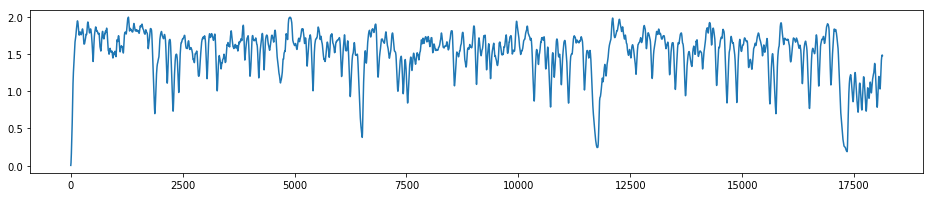

In [87]:
plt.figure(figsize=(16,3))
plt.plot(Motion_Conv)

In [88]:
s = G3_R.values
x = np.linspace(0,18246, num = 3030)

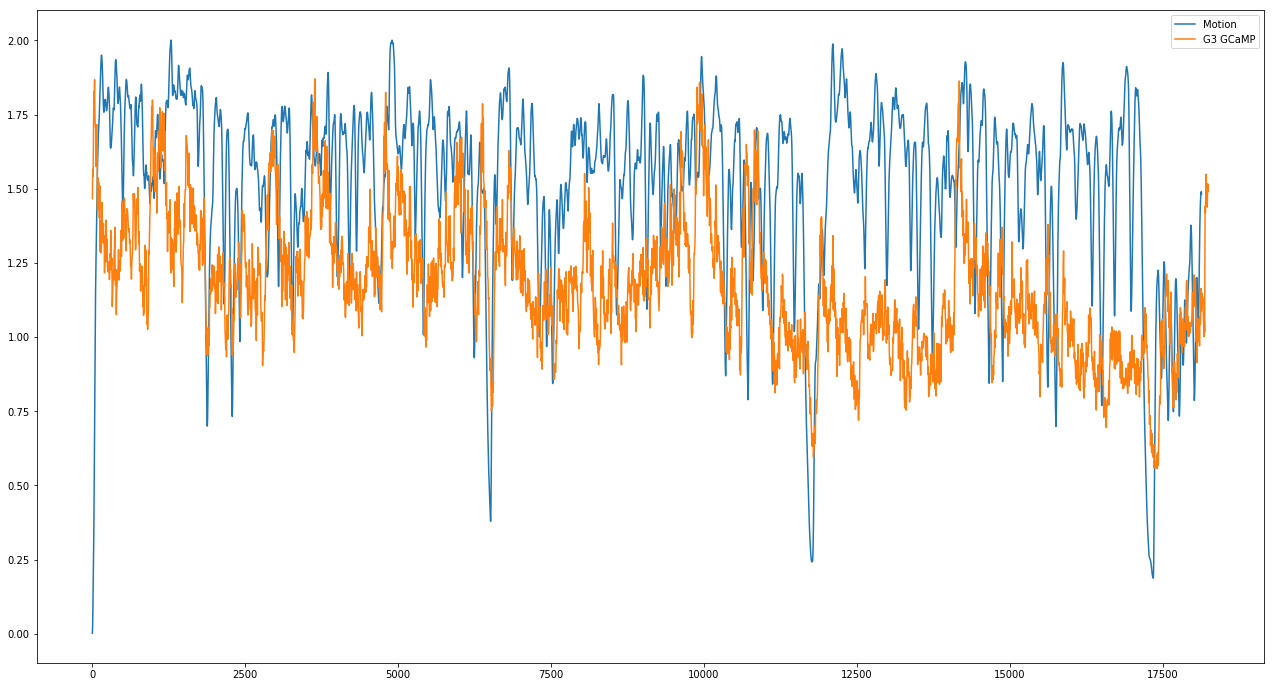

In [100]:
#%pylab qt
plt.figure(figsize=(22,12))
plt.plot(Motion_Conv)
plt.plot(x,s)
labels = ['Motion', 'G3 GCaMP']
plt.legend(labels)

In [109]:
start_times = pd.read_csv(start_stop_data_path, header=None).values[0][0]

In [179]:
Time1 = start_times

if (Time1<295) and (Time1>6):
    
    Time1_F_Diff = np.absolute(FicTrac_Time_Real-Time1)
    Frame1_F = np.where(Time1_F_Diff==(np.amin(Time1_F_Diff)))[0][0]
    
    Time1_G_Diff = np.absolute(GCaMP_Time-Time1)
    Frame1_G=np.where(Time1_G_Diff==(np.amin(Time1_G_Diff)))[0][0]
    
    Time_F_Bout=FicTrac_Time_Real[(Frame1_F-300):(Frame1_F+300)];
    Time_G_Bout=GCaMP_Time[(Frame1_G-50):(Frame1_G+50)];

#Avg the Motion data leading up to each timepoint when GCaMP capture occured
    Motion_Bout_Avg=[]
    for i in range(Time_G_Bout.shape[0]):
        T = Time_G_Bout[i]
        Time_Diff=np.absolute(FicTrac_Time_Real-T)
        Minimum=np.amin(Time_Diff)
        INDEX=np.where(Time_Diff==(np.amin(Time_Diff)))[0][0]
        Motion_Bout_Avg.append((np.sum(Motion_Conv[(INDEX-2):INDEX+2]))/5)


    Motion_Bout=Motion_Bout_Avg
    G2_Bout=G2_R[(Frame1_G-50):(Frame1_G+50)].values
    G3_Bout=G3_R[(Frame1_G-50):(Frame1_G+50)].values
    G4_Bout=G4_R[(Frame1_G-50):(Frame1_G+50)].values
    G5_Bout=G5_R[(Frame1_G-50):(Frame1_G+50)].values

    G2_Corr = []
    G3_Corr = []
    G4_Corr = []
    G5_Corr = []
    
    from scipy.stats import pearsonr
    
    G2_Corr_pre = pearsonr(Motion_Bout[46:66],G2_Bout[46:66])
    G2_Corr.append(G2_Corr_pre[0])
    
    G3_Corr_pre = pearsonr(Motion_Bout[46:66],G3_Bout[46:66])
    G3_Corr.append(G3_Corr_pre[0])
    
    G4_Corr_pre = pearsonr(Motion_Bout[46:66],G4_Bout[46:66])
    G4_Corr.append(G4_Corr_pre[0])
    
    G5_Corr_pre = pearsonr(Motion_Bout[46:66],G5_Bout[46:66])
    G5_Corr.append(G5_Corr_pre[0])
